In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score,  accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [48]:
data = pd.read_csv("labelled_data.csv")
data.dropna(inplace=True)
data

,drug_name,review_source,drug_review,tokens,concreteness,modality,sentiments,disease,side effects,side effects grouped,side effects cleaned
0,Elidel,Drugs.com,no! no! no! do not use Elidel it's worse than ...,"['use', 'elidel', 'bad', 'hydrocortisone', 'ta...",0.365854,Deontic modality,Negative,Eczema,Topical Steroid Withdrawal,Flu-like,Topical Steroid Withdrawal
1,Elidel,Drugs.com,I've been so interested to find out what other...,"['interested', 'find', 'think', 'elidel', 'suf...",0.080000,Epistemic modality,Negative,Eczema,Topical Steroid Withdrawal,Flu-like,Topical Steroid Withdrawal
2,Elidel,Drugs.com,"After being prescribed Elidel, my skin got muc...","['prescribe', 'elidel', 'skin', 'get', 'bad', ...",0.257143,Deontic modality,Negative,Eczema,"Topical Steroid Withdrawal, Weakened Immunity ...",Flu-like,"Topical Steroid Withdrawal, Weakened Immune Sy..."
3,Elidel,Drugs.com,"After having eczema most of my life, it seemed...","['have', 'eczema', 'life', 'bad', 'have', 'all...",0.258427,Deontic modality,Neutral,Eczema,"Weakened Immune System, Fatigue",Flu-like,"Weakened Immune System, Fatigue"
4,Elidel,Drugs.com,"I never leave reviews for anything, but knowin...","['leave', 'review', ' ', 'know', 'like', 'come...",0.135135,Uncertain modality,Positive,Eczema,Nil,Nil,Nil
...,...,...,...,...,...,...,...,...,...,...,...
1761,Trulicity subcutaneous,WebMD,the side effects are miserable but it does bri...,"['effect', 'miserable', 'bring', 'number']",0.000000,Deontic modality,Positive,Diabetes,Nil,Nil,Nil
1762,Trulicity subcutaneous,WebMD,This drug helped me to lose 5 lbs in one week....,"['drug', 'help', 'lose', '5', 'lbs', 'week', '...",0.210526,Epistemic modality,Positive,Diabetes,Headache,Mental-Health,Headache
1763,Trulicity subcutaneous,WebMD,I have been using it for almost 6 months now. ...,"['6', 'month', 'lose', 'considerable', 'weight...",0.080000,Epistemic modality,Positive,Diabetes,Nil,Nil,Nil
1764,Trulicity subcutaneous,WebMD,Frist week on the pen. It seems great I am not...,"['frist', 'week', 'pen', 'great', 'have', 'cra...",0.210526,Epistemic modality,Positive,Diabetes,Nil,Nil,Nil


In [49]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [50]:
def classify(train_x, train_y, test_x, test_y, \
            binary=False, ngrams = (1,1), \
            stop_words='english', min_df=1, \
            pos_class = 'side-effect',
            model = LinearSVC(),
            show_plots=True):
    
    classifier = None
    
    train_y_list = [label.split() for label in train_y]
    test_y_list = [label.split() for label in test_y]
    mlb = MultiLabelBinarizer()
    train_y_bin = mlb.fit_transform(train_y_list)    
    test_y_bin = mlb.transform(test_y_list)
    
    # Create a pipeline
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=min_df, binary=binary, ngram_range=ngrams)
    classifier = OneVsRestClassifier(model)
    pipeline = Pipeline([('tfidf', tfidf_vectorizer), ('clf', classifier)])
    
    # Fit the pipeline
    pipeline.fit(train_x, train_y_bin)
    
    # Transform test_x
    test_x_transformed = pipeline.named_steps['tfidf'].transform(test_x)
    
    # Predict labels for test_x
    predictions = pipeline.predict(test_x)
    
    # Print classification report
    print(classification_report(test_y_bin, predictions, target_names=mlb.classes_))
    
     # Plot AUC score and PRC score if show_plots is True
    if show_plots:
        if isinstance(model, LinearSVC):
            decision_values = pipeline.named_steps['clf'].decision_function(test_x_transformed)
        else:
            decision_values = pipeline.predict_proba(test_x_transformed)

        pos_class_index = list(mlb.classes_).index(pos_class)
        
        # Calculate AUC and Precision-Recall curve for the 'pos_class' only
        fpr, tpr, _ = roc_curve(test_y_bin[:, pos_class_index], decision_values[:, pos_class_index])
        roc_auc = auc(fpr, tpr)

        precision, recall, _ = precision_recall_curve(test_y_bin[:, pos_class_index], decision_values[:, pos_class_index])

        # Plot ROC curve for each class
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([-0.05, 1.05])  # Adding a bit of space before 0.0 and after 1.0 on the x-axis
        plt.ylim([-0.05, 1.05])  # Adding a bit of space before 0.0 and after 1.0 on the y-axis
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for class {pos_class}')
        plt.legend(loc="lower right")
        plt.margins(0.05)  # Add padding to the plot
        plt.show()

        # Plot Precision-Recall curve for each class
        plt.figure()
        plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
        plt.xlim([-0.05, 1.05])  # Adding a bit of space before 0.0 and after 1.0 on the x-axis
        plt.ylim([-0.05, 1.05])  # Adding a bit of space before 0.0 and after 1.0 on the y-axis
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for class {pos_class}')
        plt.legend(loc="lower left")
        plt.margins(0.05)  # Add padding to the plot
        plt.show()
        
        
        # Calculate AUC score
        auc_score = roc_auc_score(test_y_bin[:, pos_class_index], decision_values[:, pos_class_index]) * 100

        # Calculate PRC score
        prc_score = average_precision_score(test_y_bin[:, pos_class_index], decision_values[:, pos_class_index]) * 100

        print(f"{pos_class} AUC: {auc_score:.2f}%, PRC: {prc_score:.2f}%")


    return classifier,tfidf_vectorizer 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:875: UserWarning: unknown class(es) [',Irrelgular', 'Body,', 'Boils', 'Cramps,', 'Feet', 'Foot', 'Heartbeat', 'Jaundice,', 'Lightheaded', 'Paralysis', 'Seizure', 'Symptoms', 'cramps,', 'issues', 'urination', 'urination,'] will be ignored
  warnings.warn(


                    precision    recall  f1-score   support

             (Skin       0.00      0.00      0.00         0
                 ,       0.00      0.00      0.00         1
         Abdominal       1.00      0.13      0.24        15
              Acid       0.00      0.00      0.00         0
          Allergic       0.00      0.00      0.00         1
          Anxiety,       0.00      0.00      0.00         0
          Appetite       0.00      0.00      0.00         2
         Appetite,       0.00      0.00      0.00         0
         Arthritis       0.00      0.00      0.00         0
           Bladder       0.00      0.00      0.00         0
          Blisters       0.00      0.00      0.00         0
         Blisters,       0.00      0.00      0.00         1
          Bloating       0.00      0.00      0.00         4
         Bloating,       0.00      0.00      0.00         0
             Blood       0.00      0.00      0.00         0
            Blurry       0.00      0.00

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_cla

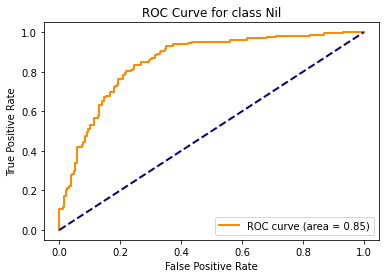

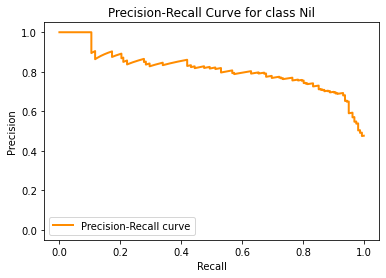

Nil AUC: 85.35%, PRC: 81.19%


In [52]:
classifier = classify(train['drug_review'], train['side effects cleaned'],
         test['drug_review'], test['side effects cleaned'],
         stop_words = 'english', binary = False, min_df = 1,
         model = LinearSVC(),
         pos_class = 'Nil',
         show_plots = True)

In [103]:
data = pd.read_excel('/Users/meetpatel/Documents/Stevens/Sem 3/BIA-660/Project/project_data.xlsx')
data.dropna(inplace=True)

In [104]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [105]:
def classify(train_x, train_y, test_x, test_y, \
            binary=False, ngrams = (1,1), \
            stop_words='english', min_df=1, \
            pos_class = 'side-effect',
            model = LinearSVC(),
            show_plots=True):
    
    classifier = None
    
    train_y_list = [label.split(',') for label in train_y]
    test_y_list = [label.split(',') for label in test_y]
    mlb = MultiLabelBinarizer()
    train_y_bin = mlb.fit_transform(train_y_list)    
    test_y_bin = mlb.transform(test_y_list)
    
    # Create a pipeline
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=min_df, binary=binary, ngram_range=ngrams)
    classifier = OneVsRestClassifier(model)
    pipeline = Pipeline([('tfidf', tfidf_vectorizer), ('clf', classifier)])
    
    # Fit the pipeline
    pipeline.fit(train_x, train_y_bin)
    
    # Transform test_x
    test_x_transformed = pipeline.named_steps['tfidf'].transform(test_x)
    
    # Predict labels for test_x
    predictions = pipeline.predict(test_x)
    
    # Print classification report
    print(classification_report(test_y_bin, predictions, target_names=mlb.classes_))
    accuracy = accuracy_score(test_y_bin, predictions)
    print(f"Accuracy: {accuracy:.2f}")
    
     # Plot AUC score and PRC score if show_plots is True
    if show_plots:
        if isinstance(model, LinearSVC):
            decision_values = pipeline.named_steps['clf'].decision_function(test_x_transformed)
        else:
            decision_values = pipeline.predict_proba(test_x_transformed)

        pos_class_index = list(mlb.classes_).index(pos_class)
        
        # Calculate AUC and Precision-Recall curve for the 'pos_class' only
        fpr, tpr, _ = roc_curve(test_y_bin[:, pos_class_index], decision_values[:, pos_class_index])
        roc_auc = auc(fpr, tpr)

        precision, recall, _ = precision_recall_curve(test_y_bin[:, pos_class_index], decision_values[:, pos_class_index])

        # Plot ROC curve for each class
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([-0.05, 1.05])  # Adding a bit of space before 0.0 and after 1.0 on the x-axis
        plt.ylim([-0.05, 1.05])  # Adding a bit of space before 0.0 and after 1.0 on the y-axis
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for class {pos_class}')
        plt.legend(loc="lower right")
        plt.margins(0.05)  # Add padding to the plot
        plt.show()

        # Plot Precision-Recall curve for each class
        plt.figure()
        plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
        plt.xlim([-0.05, 1.05])  # Adding a bit of space before 0.0 and after 1.0 on the x-axis
        plt.ylim([-0.05, 1.05])  # Adding a bit of space before 0.0 and after 1.0 on the y-axis
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for class {pos_class}')
        plt.legend(loc="lower left")
        plt.margins(0.05)  # Add padding to the plot
        plt.show()
        
        
        # Calculate AUC score
        auc_score = roc_auc_score(test_y_bin[:, pos_class_index], decision_values[:, pos_class_index]) * 100

        # Calculate PRC score
        prc_score = average_precision_score(test_y_bin[:, pos_class_index], decision_values[:, pos_class_index]) * 100

        print(f"{pos_class} AUC: {auc_score:.2f}%, PRC: {prc_score:.2f}%")


    return classifier, pipeline, mlb

/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:875: UserWarning: unknown class(es) ['Upper-Respiratory-Related '] will be ignored
  warnings.warn(
/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-d

                           precision    recall  f1-score   support

                                0.00      0.00      0.00         0
          Abdomen-Related       0.00      0.00      0.00         0
          Abdomen-Related       0.88      0.51      0.65        45
     Ache/Pain & Swelling       0.81      0.35      0.49        37
     Cardio & Eye-Related       1.00      0.45      0.62        11
                  General       0.90      0.31      0.46        29
        Metabolic-Related       0.00      0.00      0.00        15
   Nervous-System-Related       1.00      0.05      0.09        21
                      Nil       0.77      0.75      0.76       162
            Psychological       0.75      0.14      0.23        22
                     Rare       0.00      0.00      0.00         3
             Skin-Related       0.82      0.58      0.68        57
Upper-Respiratory-Related       0.00      0.00      0.00         5
          Urinary-Related       0.88      0.50      0.64     

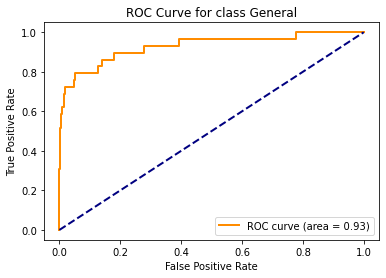

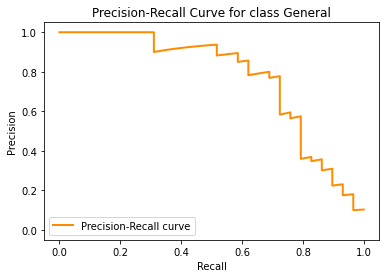

General AUC: 92.83%, PRC: 76.82%


In [106]:
classifier, pipeline, mlb = classify(train['drug_review'], train['side_effects_cleaned_grouped'],
         test['drug_review'], test['side_effects_cleaned_grouped'],
         stop_words = 'english', binary = False, min_df = 1,
         model = LinearSVC(),
         pos_class = 'General',
         show_plots = True)

In [107]:
def search_para(docs, y, model):
    
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', OneVsRestClassifier(model))
    ])

    parameters = {
        'tfidf__stop_words': [None, 'english'],
        'tfidf__min_df': [1, 2],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__estimator__C': [0.5, 1, 2]
    }


    gs_clf = GridSearchCV(pipeline, parameters, scoring='f1_macro', cv=4)
    gs_clf.fit(docs, y)
    print("Best F1 Score:", gs_clf.best_score_)

    return gs_clf.best_params_

In [108]:
best_params = search_para(train['drug_review'], train['side_effects_cleaned_grouped'], model=LinearSVC())
best_params

/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Best F1 Score: 0.06963572087493203


{'clf__estimator__C': 2,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:875: UserWarning: unknown class(es) ['Upper-Respiratory-Related '] will be ignored
  warnings.warn(
/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-d

                           precision    recall  f1-score   support

                                0.00      0.00      0.00         0
          Abdomen-Related       0.00      0.00      0.00         0
          Abdomen-Related       0.88      0.47      0.61        45
     Ache/Pain & Swelling       0.80      0.43      0.56        37
     Cardio & Eye-Related       1.00      0.45      0.62        11
                  General       0.86      0.41      0.56        29
        Metabolic-Related       0.50      0.07      0.12        15
   Nervous-System-Related       1.00      0.05      0.09        21
                      Nil       0.77      0.77      0.77       162
            Psychological       0.43      0.14      0.21        22
                     Rare       0.00      0.00      0.00         3
             Skin-Related       0.74      0.61      0.67        57
Upper-Respiratory-Related       0.00      0.00      0.00         5
          Urinary-Related       0.89      0.61      0.72     

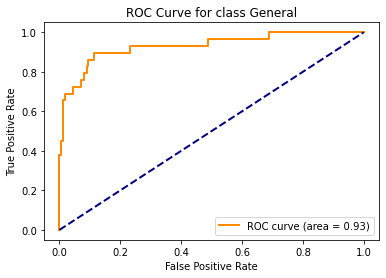

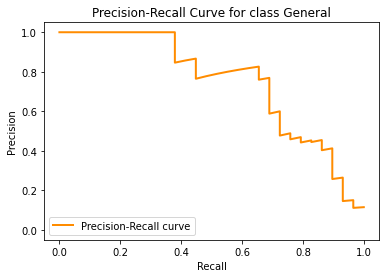

General AUC: 93.09%, PRC: 74.91%


In [109]:
classifier, pipeline, mlb = classify(train['drug_review'], train['side_effects_cleaned_grouped'],
         test['drug_review'], test['side_effects_cleaned_grouped'],
         stop_words = best_params['tfidf__stop_words'], ngrams = best_params['tfidf__ngram_range'], binary = False, min_df = best_params['tfidf__min_df'],
         pos_class = 'General',
         model = LinearSVC(C=best_params['clf__estimator__C']), 
         show_plots = True)

In [110]:
def search_para(docs, y, model):
    
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', OneVsRestClassifier(model))
    ])

    parameters = {
        'tfidf__stop_words': [None, 'english'],
        'tfidf__min_df': [1, 2],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__estimator__C': [0.5, 1, 2]
    }


    gs_clf = GridSearchCV(pipeline, parameters, scoring='f1_macro', cv=4)
    gs_clf.fit(docs, y)
    print("Best F1 Score:", gs_clf.best_score_)

    return gs_clf.best_params_

In [111]:
best_params = search_para(train['drug_review'], train['side_effects_cleaned_grouped'], model=LinearSVC(class_weight='balanced'))
best_params

/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Best F1 Score: 0.07855035818634179


{'clf__estimator__C': 0.5,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:875: UserWarning: unknown class(es) ['Upper-Respiratory-Related '] will be ignored
  warnings.warn(
/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meetpatel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-d

                           precision    recall  f1-score   support

                                0.00      0.00      0.00         0
          Abdomen-Related       0.00      0.00      0.00         0
          Abdomen-Related       0.80      0.73      0.77        45
     Ache/Pain & Swelling       0.80      0.76      0.78        37
     Cardio & Eye-Related       0.56      0.45      0.50        11
                  General       0.84      0.55      0.67        29
        Metabolic-Related       0.31      0.27      0.29        15
   Nervous-System-Related       0.38      0.14      0.21        21
                      Nil       0.77      0.78      0.77       162
            Psychological       0.40      0.36      0.38        22
                     Rare       0.00      0.00      0.00         3
             Skin-Related       0.69      0.74      0.71        57
Upper-Respiratory-Related       0.33      0.20      0.25         5
          Urinary-Related       0.83      0.71      0.77     

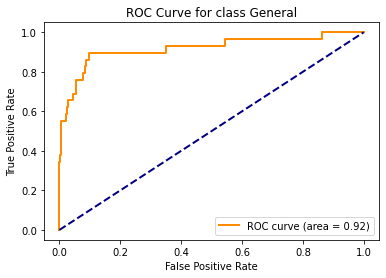

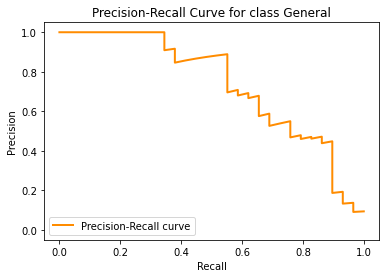

General AUC: 91.85%, PRC: 73.57%


In [112]:
classifier, pipeline, mlb = classify(train['drug_review'], train['side_effects_cleaned_grouped'],
         test['drug_review'], test['side_effects_cleaned_grouped'],
         stop_words = best_params['tfidf__stop_words'], ngrams = best_params['tfidf__ngram_range'], binary = False, min_df = best_params['tfidf__min_df'],
         pos_class = 'General',
         model = LinearSVC(C=best_params['clf__estimator__C'],class_weight='balanced'), 
         show_plots = True)

In [75]:
def predict_side_effect(classifier, review):
    prediction = classifier.predict(review)
    return prediction

user_review = input("Enter a drug review: ")

# Transform the user's input using the fitted TfidfVectorizer
input_transformed = pipeline.named_steps['tfidf'].transform([user_review])

# Get the prediction for the user-provided review
result = predict_side_effect(classifier, input_transformed)

# Retrieve the predicted side effect category
predicted_category = mlb.classes_[result]

# Print the predicted side effect category
print(f"The predicted side effect category for the review is: {predicted_category}")


Enter a drug review: used for diabetes but got really bad diarrhea. Don't recommend
The predicted side effect category for the review is: ['' '' ' Abdomen-Related' '' '' '' '' '' '' '' '' '' '' '']


In [86]:
def predict_side_effect(classifier, review):
    prediction = classifier.predict(review)
    return prediction

user_review = input("Enter a drug review: ")

# Transform the user's input using the fitted TfidfVectorizer
input_transformed = pipeline.named_steps['tfidf'].transform([user_review])

# Get the prediction for the user-provided review
result = predict_side_effect(classifier, input_transformed)

# Retrieve the predicted side effect category
predicted_category = mlb.classes_[result]

# Print the predicted side effect category
print(f"The predicted side effect category for the review is: {predicted_category}")


Enter a drug review: too much weight gain and my diabetes worserened
The predicted side effect category for the review is: [['' '' '' '' '' '' ' Abdomen-Related' '' ' Abdomen-Related' '' '' '' ''
  '']]


In [115]:
from scipy import sparse

def custom_preprocessor(doc):
    if isinstance(doc, str):
        return doc.lower()
    elif isinstance(doc, (sparse.csr_matrix, sparse.csc_matrix)):
        return doc
    else:
        raise TypeError("Unsupported input type")

def classify(train_x, train_y, test_x, test_y, \
            binary=False, ngrams = (1,1), \
            stop_words='english', min_df=1, \
            pos_class = 'side-effect',
            model = LinearSVC(),
            show_plots=True):
    
    classifier = None
    
    train_y_list = [label.split(',') for label in train_y]
    test_y_list = [label.split(',') for label in test_y]
    mlb = MultiLabelBinarizer()
    train_y_bin = mlb.fit_transform(train_y_list)    
    test_y_bin = mlb.transform(test_y_list)
    
    # Create a pipeline
    tfidf_vectorizer = TfidfVectorizer(stop_words='english',min_df=min_df,binary=False,ngram_range=ngrams,preprocessor=custom_preprocessor)
    classifier = OneVsRestClassifier(model)
    pipeline = Pipeline([('tfidf', tfidf_vectorizer), ('clf', classifier)])
    
    # Fit the pipeline
    pipeline.fit(train_x, train_y_bin)
    
    # Transform test_x
    test_x_transformed = pipeline.named_steps['tfidf'].transform(test_x)
    
    # Predict labels for test_x
    predictions = pipeline.predict(test_x)
    
    # Print classification report
    print(classification_report(test_y_bin, predictions, target_names=mlb.classes_))
    accuracy = accuracy_score(test_y_bin, predictions)
    print(f"Accuracy: {accuracy:.2f}")
    
     # Plot AUC score and PRC score if show_plots is True
    if show_plots:
        if isinstance(model, LinearSVC):
            decision_values = pipeline.named_steps['clf'].decision_function(test_x_transformed)
        else:
            decision_values = pipeline.predict_proba(test_x_transformed)

        pos_class_index = list(mlb.classes_).index(pos_class)
        
        # Calculate AUC and Precision-Recall curve for the 'pos_class' only
        fpr, tpr, _ = roc_curve(test_y_bin[:, pos_class_index], decision_values[:, pos_class_index])
        roc_auc = auc(fpr, tpr)

        precision, recall, _ = precision_recall_curve(test_y_bin[:, pos_class_index], decision_values[:, pos_class_index])

        # Plot ROC curve for each class
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([-0.05, 1.05])  # Adding a bit of space before 0.0 and after 1.0 on the x-axis
        plt.ylim([-0.05, 1.05])  # Adding a bit of space before 0.0 and after 1.0 on the y-axis
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for class {pos_class}')
        plt.legend(loc="lower right")
        plt.margins(0.05)  # Add padding to the plot
        plt.show()

        # Plot Precision-Recall curve for each class
        plt.figure()
        plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
        plt.xlim([-0.05, 1.05])  # Adding a bit of space before 0.0 and after 1.0 on the x-axis
        plt.ylim([-0.05, 1.05])  # Adding a bit of space before 0.0 and after 1.0 on the y-axis
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for class {pos_class}')
        plt.legend(loc="lower left")
        plt.margins(0.05)  # Add padding to the plot
        plt.show()
        
        
        # Calculate AUC score
        auc_score = roc_auc_score(test_y_bin[:, pos_class_index], decision_values[:, pos_class_index]) * 100

        # Calculate PRC score
        prc_score = average_precision_score(test_y_bin[:, pos_class_index], decision_values[:, pos_class_index]) * 100

        print(f"{pos_class} AUC: {auc_score:.2f}%, PRC: {prc_score:.2f}%")


    return classifier, pipeline, mlb